In [1]:
class Polynomial:
    def __init__(self, terms = None):
        # We store each term as an entry in the dictionary as ((var1, deg), (var2, deg), ...): coefficient,
        # where var1 index < var2 index < ...
        # For example, x0**2x2 - 2x0x1 + 1 will be { ((0, 2), (2, 1)): 1, ((0, 1), (1, 1)): -2, (): 1 }.
        if terms == None:
            terms = {}
        self.terms = terms.copy()
    
    def __neg__(self):
        terms = self.terms.copy()
        for variables in terms:
            terms[variables] *= -1
        return Polynomial(terms)
    
    def __add__(self, other):
        if type(other) == int or type(other) is float:
            other = const(other)
        assert type(other) == Polynomial

        terms = self.terms.copy()
        for (variables, coefficient) in other.terms.items():
            if variables in terms:
                terms[variables] += coefficient
                if abs(terms[variables]) < 1e-9:
                    del terms[variables]
            else:
                terms[variables] = coefficient
        
        return Polynomial(terms)

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        if type(other) == int or type(other) is float:
            other = const(other)
        assert type(other) == Polynomial

        terms = self.terms.copy()
        for (variables, coefficient) in other.terms.items():
            if variables in terms:
                terms[variables] -= coefficient
                if abs(terms[variables]) < 1e-9:
                    del terms[variables]
            else:
                terms[variables] = -coefficient
        
        return Polynomial(terms)

    def __rsub__(self, other):
       return -(self - other)

    def __mul__(self, other):
        if type(other) == int or type(other) is float:
            other = const(other)
        assert type(other) == Polynomial

        terms = {}
        for (variables1, coefficient1) in self.terms.items():
            for (variables2, coefficient2) in other.terms.items():
                coefficient = coefficient1 * coefficient2
                variables = {}
                for (variable, degree) in variables1:
                    variables[variable] = degree
                for (variable, degree) in variables2:
                    if variable in variables:
                        variables[variable] += degree
                    else:
                        variables[variable] = degree
                variables = tuple(sorted(list(variables.items())))
                
                if variables in terms:
                    terms[variables] += coefficient
                else:
                    terms[variables] = coefficient

        terms_keys = list(terms.keys())
        for key in terms_keys:
            if terms[key] == 0:
                del terms[key]
        
        return Polynomial(terms)

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        res = const(1)
        for _ in range(other):
            res *= self
        return res

    def __repr__(self):
        return " + ".join([
            f"{coefficient if coefficient != 1 or len(variables) == 0 else ""}" + "".join([
                f"x{index}{f"^{degree}" if degree != 1 else ""}" for (index, degree) in variables
            ])
            for (variables, coefficient) in self.terms.items()
        ])
    
    def number_of_variables(self):
        res = 0
        for variables in self.terms:
            for (index, _) in variables:
                res = max(res, index + 1)
        return res

    def __call__(self, val):
        if type(val) == float or type(val) == int:
            val = (val,)
        assert len(val) == self.number_of_variables()

        res = 0
        for (variables, coefficient) in self.terms.items():
            prod = coefficient
            for (index, degree) in variables:
                prod *= val[index] ** degree
            res += prod
        return res

def const(val):
    return Polynomial({(): val})

def var(index):
    return Polynomial({((index, 1),): 1})

In [2]:
import random

def integral(polynomial: Polynomial, region):
    if type(region[0]) == int or type(region[0]) == float:
        region = [region]
    n = polynomial.number_of_variables()
    assert n == len(region)

    res = 0
    for (variables, coefficient) in polynomial.terms.items():
        degrees = [0] * n
        for (index, degree) in variables:
            degrees[index] = degree
        
        integral = coefficient
        for i in range(n):
            integral *= region[i][1] ** (degrees[i] + 1) / (degrees[i] + 1) - region[i][0] ** (degrees[i] + 1) / (degrees[i] + 1)
        res += integral
    
    return res

def grid_integral(f, region, n = 10, cell_offset = 0.0):
    if type(region[0]) == int or type(region[0]) == float:
        region = [region]

    counter = [0] * len(region)
    res = 0
    cell_volume = 1
    for (a, b) in region:
        cell_volume *= (b - a) / n

    loop = True
    while loop:
        res += f([region[i][0] + (counter[i] + cell_offset) / n * (region[i][1] - region[i][0]) for i in range(len(counter))]) * cell_volume
        loop = False
        for i in range(len(counter) - 1, -1, -1):
            if counter[i] == n - 1:
                counter[i] = 0
            else:
                counter[i] += 1
                loop = True
                break
    return res

def monte_carlo_integral(f, region, n = 10):
    if type(region[0]) == int or type(region[0]) == float:
        region = [region]

    res = 0
    for _ in range(n):
        x = [region[i][0] + random.random() * (region[i][1] - region[i][0]) for i in range(len(region))]
        res += f(x)
    res /= n

    volume = 1
    for (a, b) in region:
        volume *= (b - a)
    res *= volume

    return res

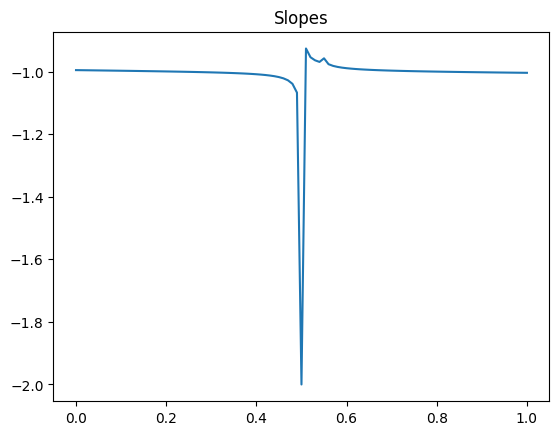

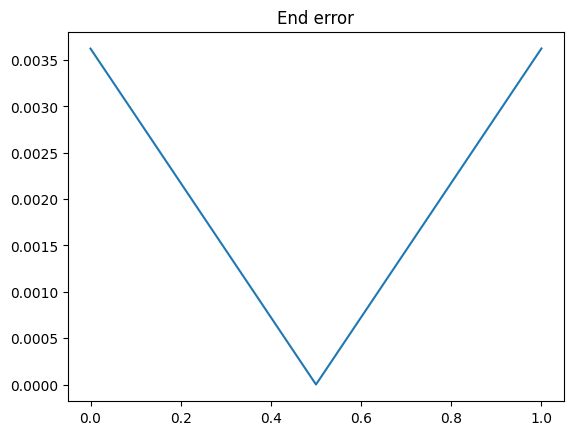

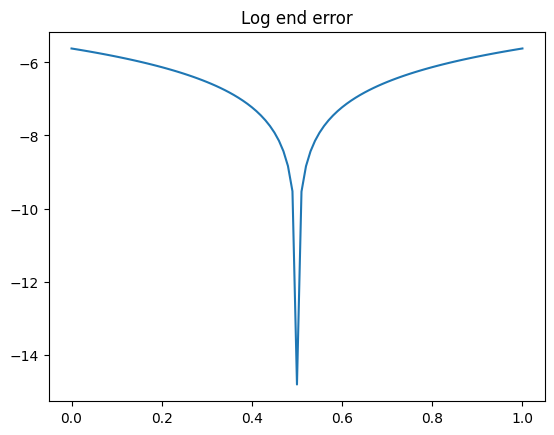

In [3]:
# Effect of offset

import matplotlib.pyplot as plt
import math
import random
from sklearn.linear_model import LinearRegression

x0 = var(0)
x1 = var(1)
x2 = var(2)
x3 = var(3)
x4 = var(4)
polynomial = (20 * random.random() - 10) * x0 ** 2 + (20 * random.random() - 10) * x0 + (20 * random.random() - 10)
region = (0, 1)

actual_integral = integral(polynomial, region)

N = 1000
offsets = [i / 100 * 1.0 for i in range(0, 101)]
slopes = []
end_errors = []
for offset in offsets:
    errors = []
    for i in range(1, N + 1):
        errors.append(abs(actual_integral - grid_integral(polynomial, region, i, cell_offset=offset)))
    line = LinearRegression().fit([[math.log(i)] for i in range(1, N + 1)], [math.log(err) for err in errors])
    slopes.append(line.coef_[0])
    end_errors.append(errors[-1])

plt.plot(offsets, slopes)
plt.title('Slopes')
plt.show()

plt.plot(offsets, end_errors)
plt.title('End error')
plt.show()

plt.plot(offsets, [math.log(err) for err in end_errors])
plt.title('Log end error')
plt.show()

1
Grid integral time 28.314172744750977
Grid integral abs error 0.5915316532316695
Midpoint grid integral time 22.04763436317444
Midpoint grid integral abs error 0.01580382898471555
Monte carlo integral time 18.993156671524048
Monte carlo abs error 0.049963053641459254
Prob that monte carlo is better 0.36


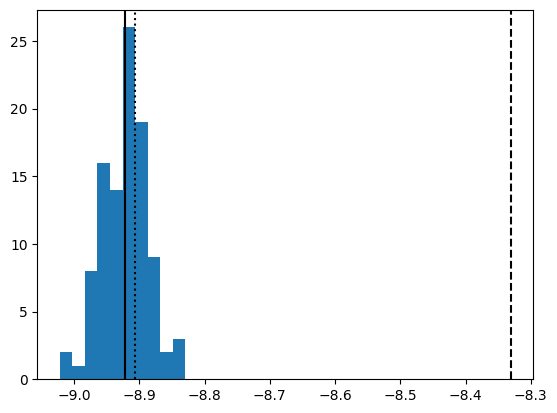

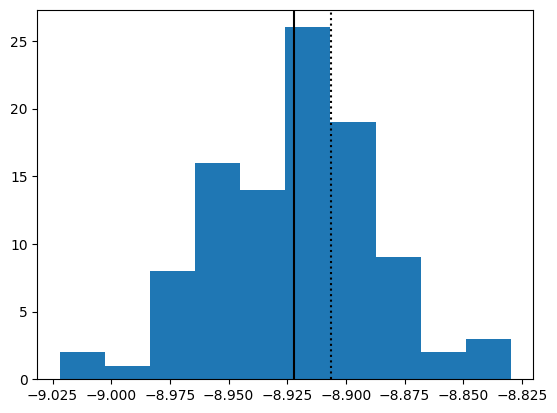

2
Grid integral time 15.09736156463623
Grid integral abs error 0.6152799907683519
Midpoint grid integral time 15.186249732971191
Midpoint grid integral abs error 0.018483226889050464
Monte carlo integral time 15.30071234703064
Monte carlo abs error 0.0162316800216038
Prob that monte carlo is better 0.59


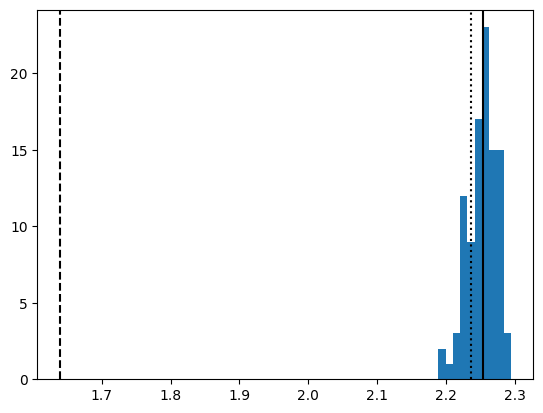

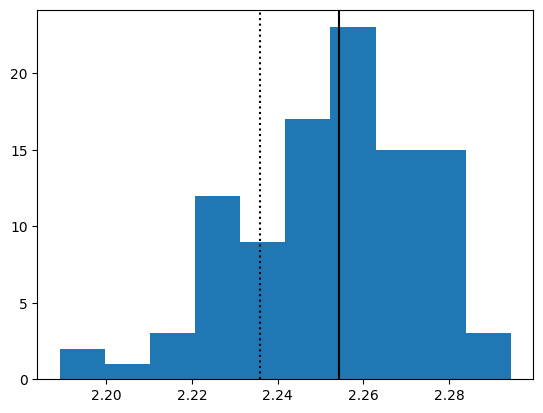

3
Grid integral time 14.948777198791504
Grid integral abs error 4.752362819845272
Midpoint grid integral time 15.20508074760437
Midpoint grid integral abs error 0.06988117965374663
Monte carlo integral time 15.166065454483032
Monte carlo abs error 0.0320999658724368
Prob that monte carlo is better 0.81


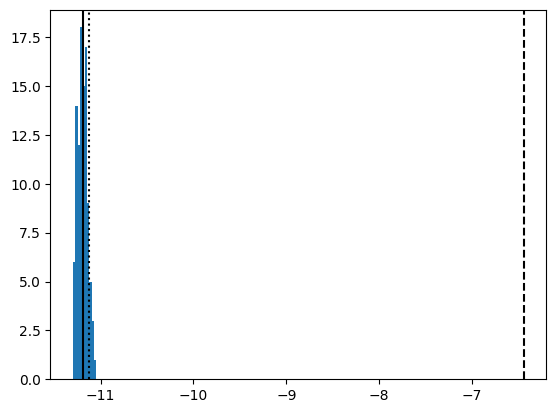

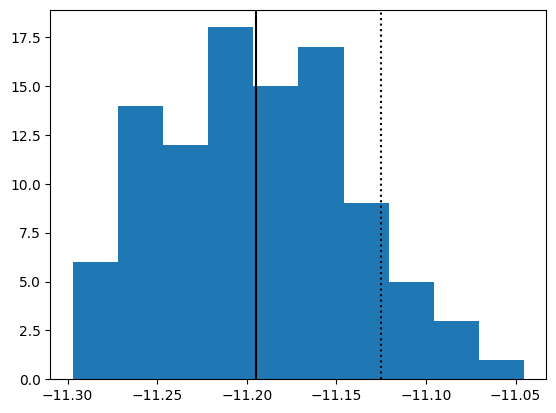

4
Grid integral time 15.020786762237549
Grid integral abs error 0.3643636613229777
Midpoint grid integral time 16.486138582229614
Midpoint grid integral abs error 0.0021254797044534257
Monte carlo integral time 15.246437788009644
Monte carlo abs error 0.040282284740227325
Prob that monte carlo is better 0.06


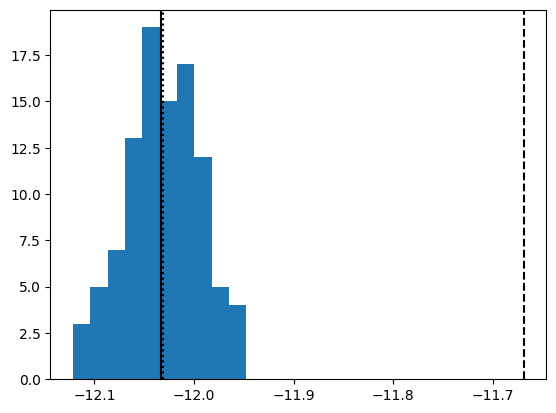

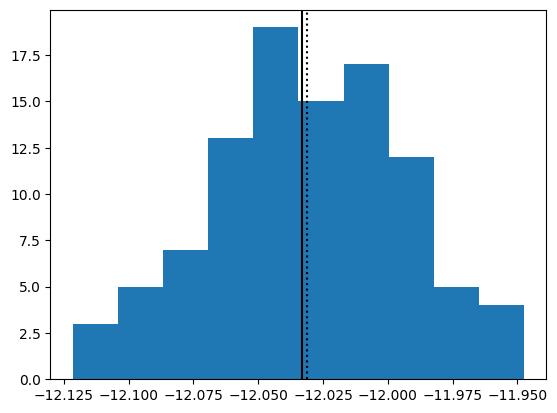

5
Grid integral time 14.95949101448059
Grid integral abs error 0.6710650832286107
Midpoint grid integral time 15.20281982421875
Midpoint grid integral abs error 0.0005666982789653829
Monte carlo integral time 15.094637393951416
Monte carlo abs error 0.02290317553756216
Prob that monte carlo is better 0.01


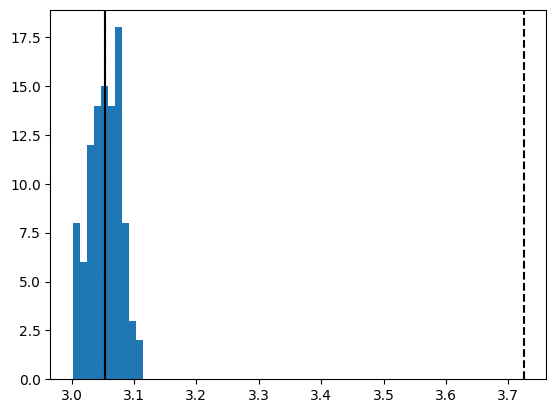

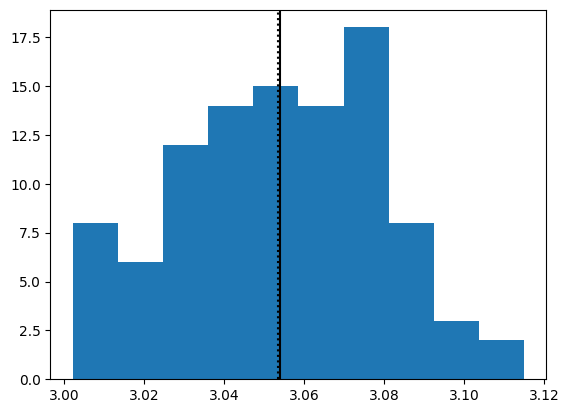

In [4]:
# Grid (0 offset) vs Monte carlo
import time

for i in range(5):
    print(i + 1)
    polynomial = 0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    for m in range(3):
                        polynomial += (20 * random.random() - 10) * x0 ** i * x1 ** j * x2 ** k * x3 ** l * x4 ** m
    region = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

    grid_n = 10
    monte_carlo_n = grid_n ** len(region)

    actual_integral = integral(polynomial, region)

    start = time.time()
    grid_estimate = grid_integral(polynomial, region, grid_n)
    print('Grid integral time', time.time() - start)
    print('Grid integral abs error', abs(grid_estimate - actual_integral))

    start = time.time()
    midpoint_grid_estimate = grid_integral(polynomial, region, grid_n, cell_offset=0.5)
    print('Midpoint grid integral time', time.time() - start)
    print('Midpoint grid integral abs error', abs(midpoint_grid_estimate - actual_integral))

    start = time.time()
    monte_carlo_estimate = monte_carlo_integral(polynomial, region, monte_carlo_n)
    print('Monte carlo integral time', time.time() - start)
    print('Monte carlo abs error', abs(monte_carlo_estimate - actual_integral))

    N = 100
    monte_better_count = 0
    monte_carlo_integrals = []
    for _ in range(N):
        monte_carlo_estimate = monte_carlo_integral(polynomial, region, monte_carlo_n)
        monte_carlo_integrals.append(monte_carlo_estimate)
        if abs(monte_carlo_estimate - actual_integral) < min(abs(grid_estimate - actual_integral), abs(midpoint_grid_estimate - actual_integral)):
            monte_better_count += 1
    print('Prob that monte carlo is better', monte_better_count / N)

    plt.hist(monte_carlo_integrals)
    plt.axvline(x = actual_integral, color = "black")
    plt.axvline(x = grid_estimate, color = "black", linestyle="--")
    plt.axvline(x = midpoint_grid_estimate, color = "black", linestyle=":")
    plt.show()

    plt.hist(monte_carlo_integrals)
    plt.axvline(x = actual_integral, color = "black")
    plt.axvline(x = midpoint_grid_estimate, color = "black", linestyle=":")
    plt.show()